In [53]:
import csv
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

In [37]:
csv_file_path = 'sim_with_razor.csv'
column_name = 'Dark Photon Produced'

# Open the CSV file
with open(csv_file_path, mode='r', encoding='utf-8') as file:
    reader = csv.DictReader(file)
    true_rows = []
    
    for row in reader:
        if row[column_name].lower() == 'true':
            true_rows.append(row)


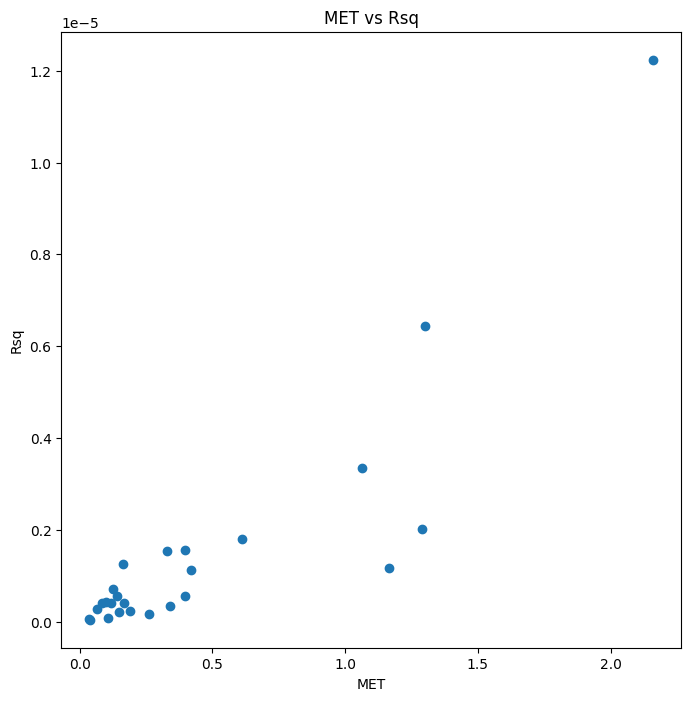

In [38]:
HT = [float(row['HT']) for row in true_rows]
MET = [float(row['MET']) for row in true_rows]
Rsq = [float(row['Rsq']) for row in true_rows]

# Creating scatter plots
plt.figure(figsize=(8, 8))  

# MET vs Rsq
plt.scatter(MET, Rsq)
plt.xlabel('MET')
plt.ylabel('Rsq')
plt.title('MET vs Rsq')

plt.show()

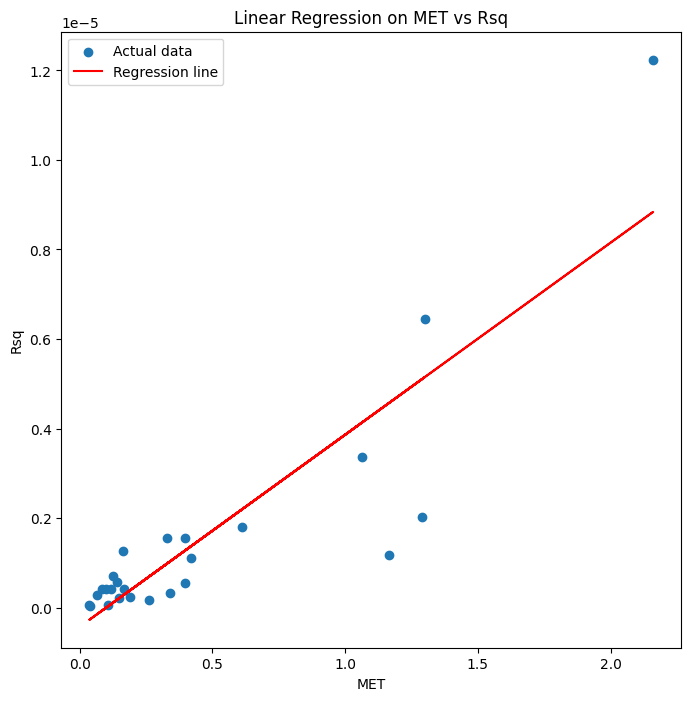

In [39]:
MET_array = np.array(MET).reshape(-1, 1)  # Features need to be 2D for sklearn
Rsq_array = np.array(Rsq)  # Target can be 1D

# Initializing and fitting the linear regression model
model = LinearRegression()
model.fit(MET_array, Rsq_array)

# Predictions for the line
Rsq_pred = model.predict(MET_array)

# Plotting MET vs Rsq with the regression line
plt.figure(figsize=(8, 8))
plt.scatter(MET, Rsq, label='Actual data')
plt.plot(MET, Rsq_pred, color='red', label='Regression line')
plt.xlabel('MET')
plt.ylabel('Rsq')
plt.title('Linear Regression on MET vs Rsq')
plt.legend()

plt.show()

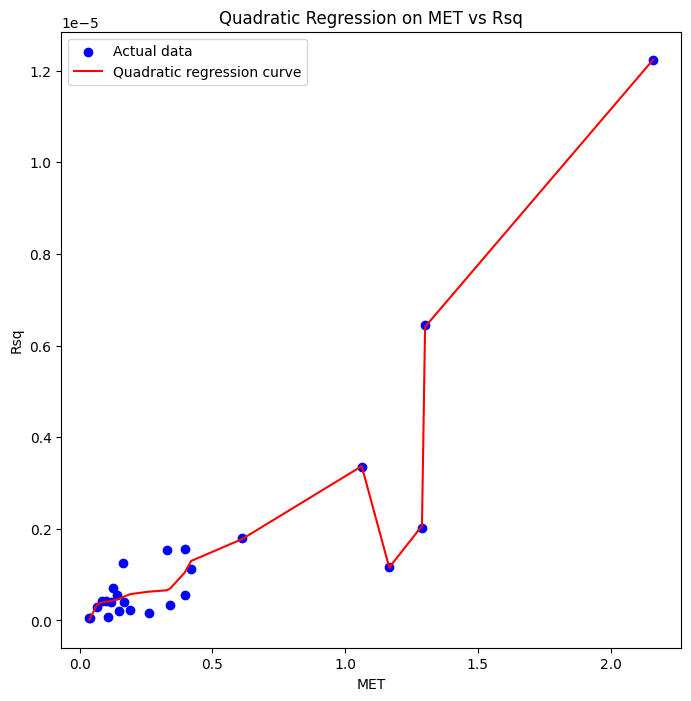

In [63]:
poly = PolynomialFeatures(degree=6)
MET_poly = poly.fit_transform(MET_array)

model_poly = LinearRegression()
model_poly.fit(MET_poly, Rsq_array)

Rsq_pred_poly = model_poly.predict(MET_poly)

sorted_zip = sorted(zip(MET, Rsq_pred_poly))
MET_sorted, Rsq_pred_poly_sorted = zip(*sorted_zip)

plt.figure(figsize=(8, 8))
plt.scatter(MET, Rsq, color='blue', label='Actual data')
plt.plot(MET_sorted, Rsq_pred_poly_sorted, color='red', label='Quadratic regression curve')
plt.xlabel('MET')
plt.ylabel('Rsq')
plt.title('Quadratic Regression on MET vs Rsq')
plt.legend()

plt.show()

In [43]:
mse_linear = mean_squared_error(Rsq_array, Rsq_pred)
mse_quadratic = mean_squared_error(Rsq_array, Rsq_pred_poly)

mse_linear, mse_quadratic

(1.5701956428333195e-12, 7.568803080501509e-13)

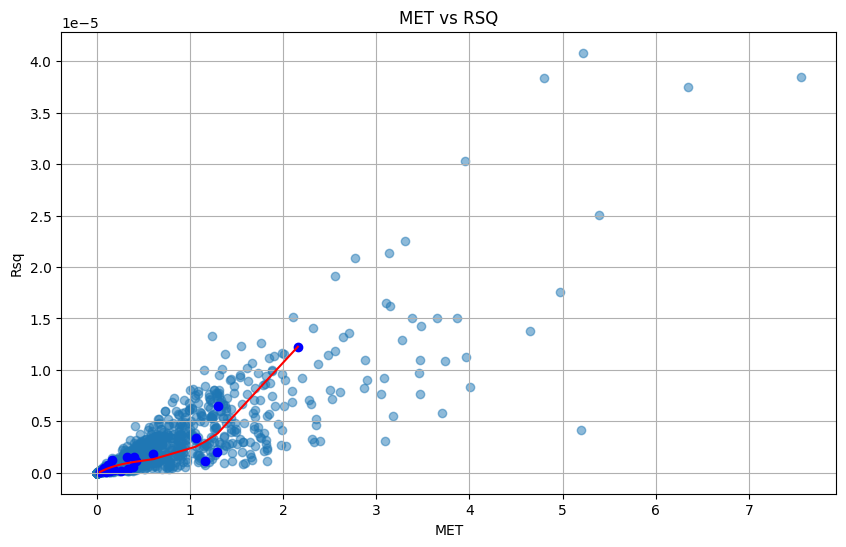

In [62]:
df = pd.read_csv('sim_with_razor.csv')

if len(df) > 1000:
    df_sampled = df.sample(n=10000, random_state=1)
else:
    df_sampled = df

# Graph MET vs RSQ
plt.figure(figsize=(10, 6))
plt.scatter(df_sampled['MET'], df_sampled['Rsq'], alpha=0.5)
plt.title('MET vs RSQ')
plt.scatter(MET, Rsq, color='blue', label='Actual data')
plt.plot(MET_sorted, Rsq_pred_poly_sorted, color='red', label='Quadratic regression curve')
plt.xlabel('MET')
plt.ylabel('Rsq')
plt.grid(True)
plt.show()

In [60]:
coefficients = model_poly.coef_
intercept = model_poly.intercept_

a = coefficients[2]
b = coefficients[1]
c = intercept

quadratic_equation = f'y = {a}x^2 + {b}x + {c}'
quadratic_equation

'y = 2.842275124477348e-06x^2 + -8.820146506113014e-07x + 5.428435052686443e-07'